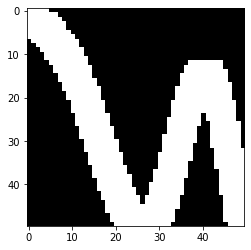

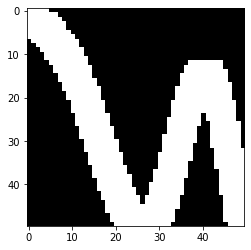

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def spline_interpolation(x, y, t):
    nx = len(x)
    
    h = torch.tensor(np.diff(x), dtype=torch.float32)
    a = torch.tensor(y, dtype=torch.float32)
    A = torch.zeros((nx, nx), dtype=torch.float32)
    
    A[0, 0] = 1.0
    for i in range(nx - 1):
        if i != (nx - 2):
            A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])
        A[i + 1, i] = h[i]
        A[i, i + 1] = h[i]

    A[0, 1] = 0.0
    A[nx - 1, nx - 2] = 0.0
    A[nx - 1, nx - 1] = 1.0
    
    B = torch.zeros(nx, dtype=torch.float32)
    for i in range(nx - 2):
        B[i + 1] = 3.0 * (a[i + 2] - a[i + 1]) / h[i + 1] - 3.0 * (a[i + 1] - a[i]) / h[i]
        
    c, _ = torch.solve(B.unsqueeze(-1), A)
    c = c.squeeze()

    b, d = [], []
    for i in range(nx - 1):
        d.append((c[i + 1] - c[i]) / (3.0 * h[i]))
        tb = (a[i + 1] - a[i]) / h[i] - h[i] * (c[i + 1] + 2.0 * c[i]) / 3.0
        b.append(tb)
    
    if t < x[0] or t > x[-1]:
        return 0.0
    

    i = torch.searchsorted(torch.tensor(x), t) - 1
    
    dx = t - x[i]
    calc = a[i] + b[i] * dx + c[i] * dx ** 2.0 + d[i] * dx ** 3.0

    return calc

def get_spline_stroke_brush(x, y, r):
    pixel_width = r
    
    increment = torch.tensor(0.01, dtype=torch.float32)
    num_steps = int((x.max() - x.min()) / increment)
    result = torch.arange(x.min(), x.max(), increment, dtype=torch.float32)
    
    rx = result
    ry = []
    

    for i in rx:
        b = spline_interpolation(x, y, i)
        ry.append(b)
    
    ry = np.concatenate((np.array([ry[1]]), ry[1::]))
    
    rx = torch.Tensor(rx)
    ry = torch.Tensor(ry)
        
    coordinates = torch.cat((rx.unsqueeze(1), ry.unsqueeze(1)), dim=1)

    canvas_size = (50, 50)
    canvas = torch.zeros(canvas_size, dtype=torch.float32).to('cpu')

    x_min, _ = torch.min(coordinates[:, 0], dim=0)
    x_max, _ = torch.max(coordinates[:, 0], dim=0)
    y_min, _ = torch.min(coordinates[:, 1], dim=0)
    y_max, _ = torch.max(coordinates[:, 1], dim=0)


    # Calculate x_coordinates and y_coordinates
    x_coordinates = ((coordinates[:, 0] - x_min) / (x_max - x_min) * (canvas_size[0] - 1)).long()
    y_coordinates = ((coordinates[:, 1] - y_min) / (y_max - y_min) * (canvas_size[1] - 1)).long()

    # Create a mask to represent the pixels to be set to 1.0
    mask = torch.zeros(canvas_size, dtype=torch.float32)
    for i in range(-pixel_width // 2, pixel_width // 2 + 1):
        for j in range(-pixel_width // 2, pixel_width // 2 + 1):
            x_mask = (0 <= x_coordinates + i) & (x_coordinates + i < canvas_size[0])
            y_mask = (0 <= y_coordinates + j) & (y_coordinates + j < canvas_size[1])
            valid_mask = x_mask & y_mask
            mask[y_coordinates[valid_mask] + j, x_coordinates[valid_mask] + i] = 1.0

    # Set the pixels in the canvas using the mask
    canvas = torch.max(canvas, mask)
    
    canvas = canvas.flip(0)
    
    stacked_canvas = torch.stack([canvas, canvas, canvas], dim=-1)
    
    return stacked_canvas

size = 2 #batch_size (1, size)

sx1 = torch.tensor([0]*size)
sx2 = torch.tensor([2]*size)
sx3 = torch.tensor([5]*size)
sx4 = torch.tensor([7]*size)
sx5 = torch.tensor([8]*size)

sy1 = torch.tensor([3]*size)
sy2 = torch.tensor([2]*size)
sy3 = torch.tensor([0]*size)
sy4 = torch.tensor([2]*size)
sy5 = torch.tensor([0]*size)

brush_radius = [5]*size

#you can combine or alter the above vectors as per your need

sx = [sx1, sx2, sx3, sx4, sx5]

sy = [sy1, sy2, sy3, sy4, sy5]
    
sx = torch.stack([sx1, sx2, sx3, sx4, sx5], dim=-1)
sy = torch.stack([sy1, sy2, sy3, sy4, sy5], dim=-1)

W = 1
H = 1

brush = []

#start by vectorizing this loop
for x,y,r in zip(sx, sy, brush_radius):
    tempbrush = get_spline_stroke_brush(x,y,r)
    brush.append(tempbrush)

for ii in brush:
    plt.imshow(ii)
    plt.show()

In [3]:
!conda env export > spline.yml